In [1]:
# --- Cell 1: Imports and Setup ---

import pandas as pd
import numpy as np
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- Cell 2: Data Loading (Automatic) and Cleanup ---

# 🚨 DEFINITIVE FILE PATH 🚨
# Using raw string (r'...') to handle backslashes in the absolute path
FILE_PATH = r"C:\Users\shrut\OneDrive\Desktop\credit_card_detection\creditcard.csv"

print("--- Starting Phase 1: Data Preparation ---")

try:
    print(f"Attempting standard data load from: {FILE_PATH}")
    
    # Standard load using comma separator. Column names are detected automatically.
    df = pd.read_csv(FILE_PATH, sep=',')
    
    # CRITICAL CLEANUP: Remove any hidden spaces/quotes from column names left by extraction
    df.columns = df.columns.str.replace('"', '').str.strip()

    # Convert all columns to numeric, handling any stray non-numeric values
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    print(f"Data loaded and cleaned successfully. Total shape: {df.shape}")

except FileNotFoundError:
    print(f"🚨 ERROR: File not found. Please verify the path: {FILE_PATH}")
    exit()
except Exception as e:
    print(f"🚨 FATAL ERROR during data loading. Details: {e}")
    exit()

print("\nFirst 5 rows of the dataset:")
print(df.head()) 

print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True) * 100)

--- Starting Phase 1: Data Preparation ---
Attempting standard data load from: C:\Users\shrut\OneDrive\Desktop\credit_card_detection\creditcard.csv
Data loaded and cleaned successfully. Total shape: (284807, 31)

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.2

In [3]:
# --- Cell 3: Feature Scaling and Saving the Scaler ---

print("\nScaling 'Time' and 'Amount' features...")

# Fit the StandardScaler on the raw 'Time' and 'Amount' features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Time', 'Amount']]) 

# Save the fitted scaler (REQUIRED for Streamlit deployment)
joblib.dump(scaler, 'scaler_for_time_amount.pkl') 
print("✅ Scaler saved as 'scaler_for_time_amount.pkl'")

# Replace original columns with scaled versions and drop originals
df['Time_Scaled'] = scaled_data[:, 0]
df['Amount_Scaled'] = scaled_data[:, 1]
df.drop(['Time', 'Amount'], axis=1, inplace=True)


Scaling 'Time' and 'Amount' features...
✅ Scaler saved as 'scaler_for_time_amount.pkl'


In [4]:
# --- Cell 4: Data Splitting, NaN Fix, and Imbalance Correction ---

print("\nCleaning NaNs from target variable and splitting data...")

# CRITICAL FIX: Drop rows where the 'Class' column (our target) is NaN
df.dropna(subset=['Class'], inplace=True)

# Define features (X) and target (Y) using the CLEANED DataFrame
X = df.drop('Class', axis=1)
Y = df['Class']

# Split data: Test set remains UNBALANCED (stratify maintains class ratios)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Apply Random Under-Sampling to the training data only (BALANCING)
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_resampled, Y_train_resampled = rus.fit_resample(X_train, Y_train)

print(f"\nOriginal Training Samples (Fraud/Non-Fraud): {Y_train.value_counts()}")
print(f"Resampled Training Samples (Fraud/Non-Fraud): {Y_train_resampled.value_counts()}")
print("Data splitting and resampling completed successfully.")


Cleaning NaNs from target variable and splitting data...

Original Training Samples (Fraud/Non-Fraud): Class
0    227451
1       394
Name: count, dtype: int64
Resampled Training Samples (Fraud/Non-Fraud): Class
0    394
1    394
Name: count, dtype: int64
Data splitting and resampling completed successfully.


In [5]:
# --- Cell 5: Model Training and Saving ---

print("\n--- Starting Phase 2: Model Training and Evaluation ---")

# --- STEP 4: Model Training and Saving ---

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model using the BALANCED (resampled) training data
model.fit(X_train_resampled, Y_train_resampled)
print("Model training complete.")

# Save the trained model (REQUIRED for Streamlit deployment)
joblib.dump(model, 'fraud_detection_rf_model.pkl') 
print("✅ Trained model saved as 'fraud_detection_rf_model.pkl'")


--- Starting Phase 2: Model Training and Evaluation ---
Model training complete.
✅ Trained model saved as 'fraud_detection_rf_model.pkl'



--- Model Evaluation (Focus on Class 1: Fraud) ---
Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.96      0.98     56864
    Fraud (1)       0.04      0.92      0.08        98

     accuracy                           0.96     56962
    macro avg       0.52      0.94      0.53     56962
 weighted avg       1.00      0.96      0.98     56962



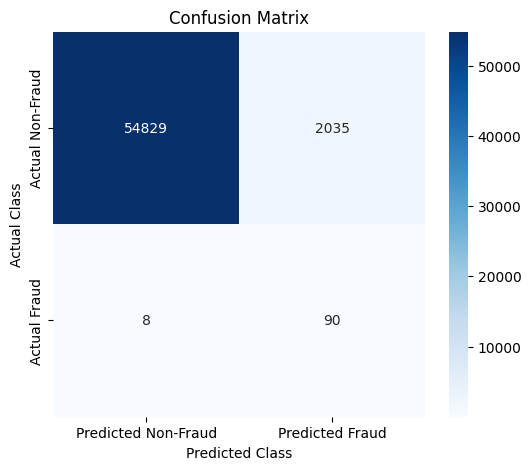

In [7]:
# --- Cell 6: Model Evaluation and Visualization (FIXED) ---

# Predict on the UNBALANCED test set for a real-world performance view
Y_pred = model.predict(X_test)

print("\n--- Model Evaluation (Focus on Class 1: Fraud) ---")
print("Classification Report:")
report = classification_report(Y_test, Y_pred, target_names=['Non-Fraud (0)', 'Fraud (1)'])
print(report)

# Confusion Matrix Visualization
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()